# Generating gaits

The next step in developing the robot kinematics is to generate various gaits. First, lets familiarize ourselves with the concept of gaits. Gait is a coordinated sequence of movements of the robot legs and body to achieve smooth locomotion.

The two most common gaits are the tripod gait and the ripple gait. The tripod gait is a simple gait where the robot moves one leg at a time, while the ripple gait is a more complex gait where the legs move in a wave-like motion.

To get an idea of the variance and complexity between gaits, Fig 1. shows four typical gaits. The six legs, right and left hind, middle and front, indicated as RH, RM, RF, LH, LM, and LF, at any one time are either on the ground pushing forward (supporting) shown in white, or in the air moving up to their next position (recovering) shown in black. [borrowed from hexapodrobot.weebly.com](https://hexapodrobot.weebly.com/the-legs.html)

<div>
<img src="hexapod_gaits.png" width="600"/>
</div>

Fig 1. Four typical hexapodal gaits, depicting each of the six legs as either supporting (white) or recovering (black). Image source: (Chen et al. 2012)



## Tripod gait, one leg at a time

The tripod gait is a simple gait where the robot moves one leg at a time. The robot moves one leg forward, then the other leg forward, then the third leg forward. This is repeated until the robot has moved all three legs forward.

Parametrization of the tripod gait is done by specifying the following parameters:

  1. Leg swing angle
  2. Leg stance angle
  3. Leg lift angle
  4. Leg lift time
  5. Leg swing time
  6. Leg stance time

As before, we are going to start with simple 2D plots to build intuition via simple visualizations.

In [13]:
# Enable python modules live reloading
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

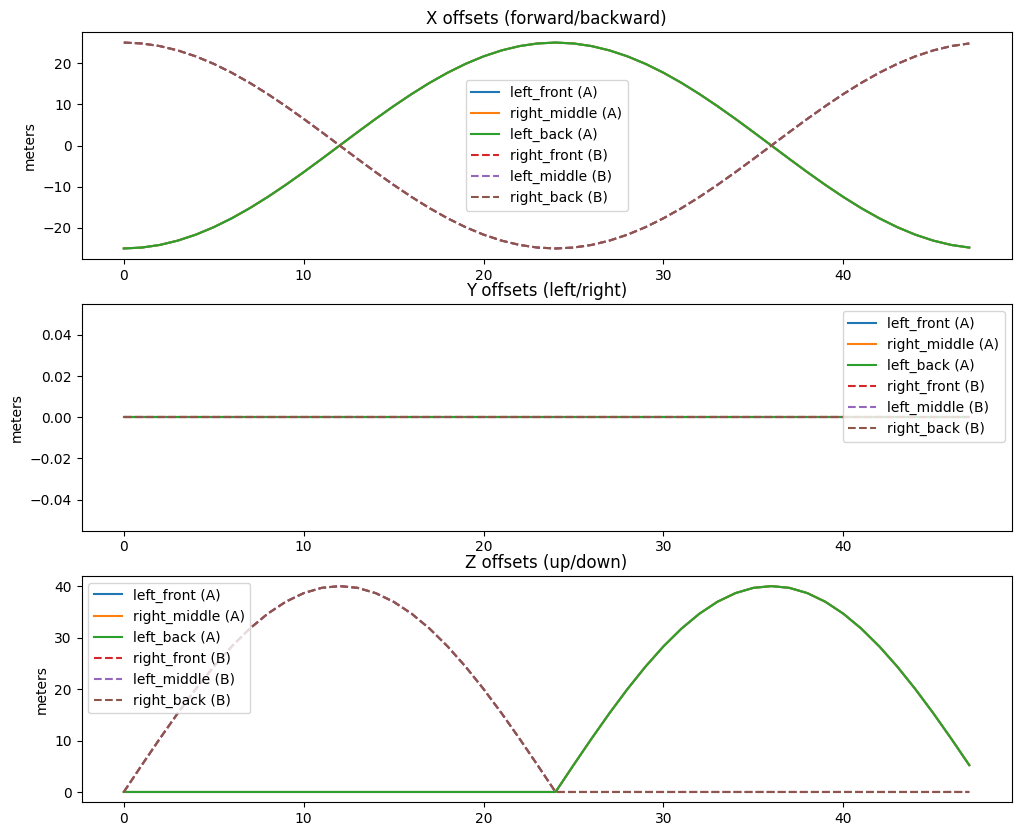

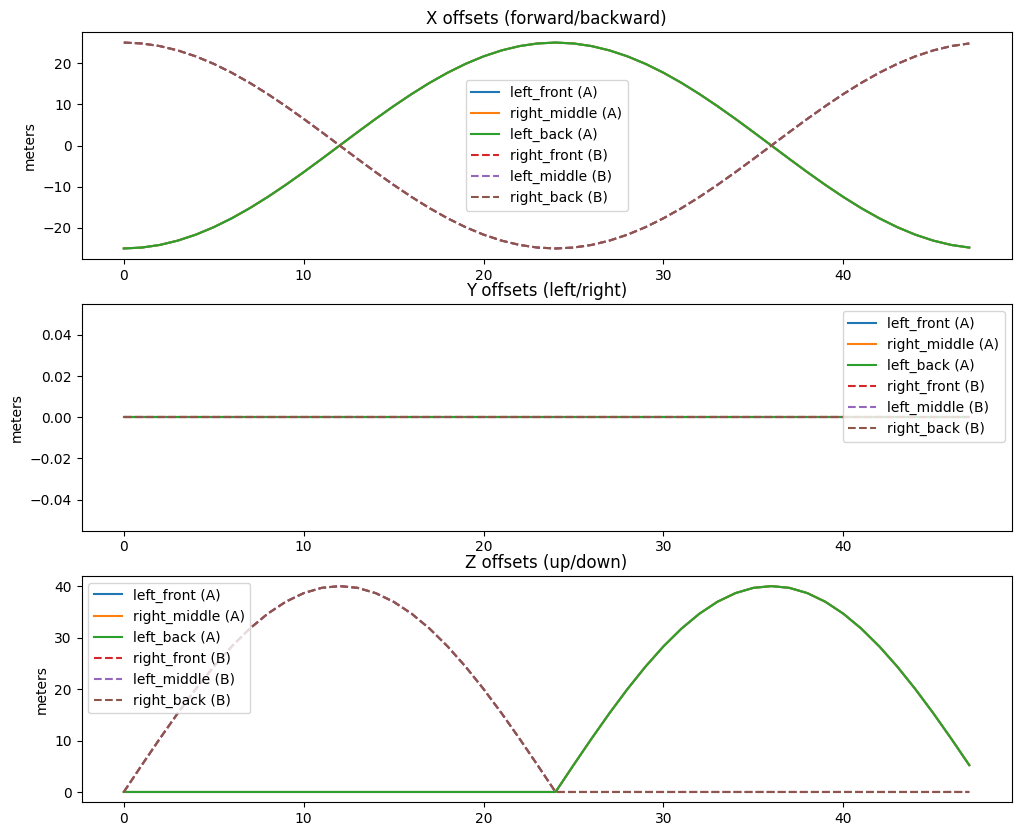

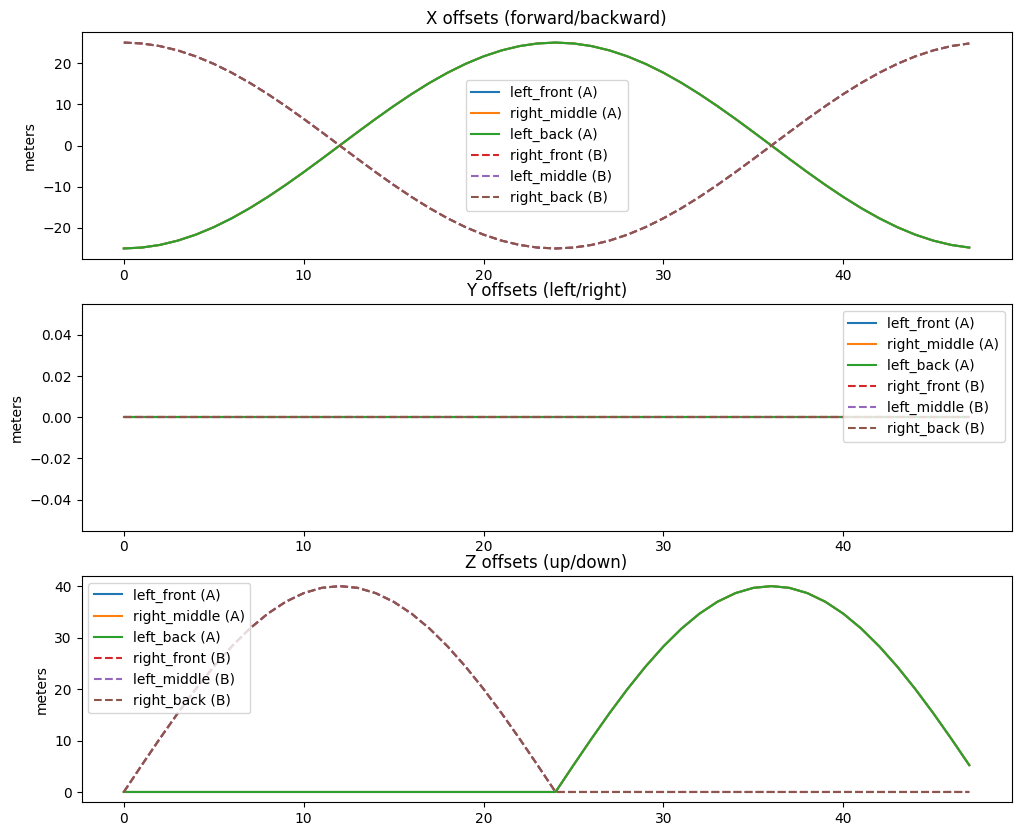

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

ValueError: 'bboxes' cannot be empty

<Figure size 640x480 with 1 Axes>

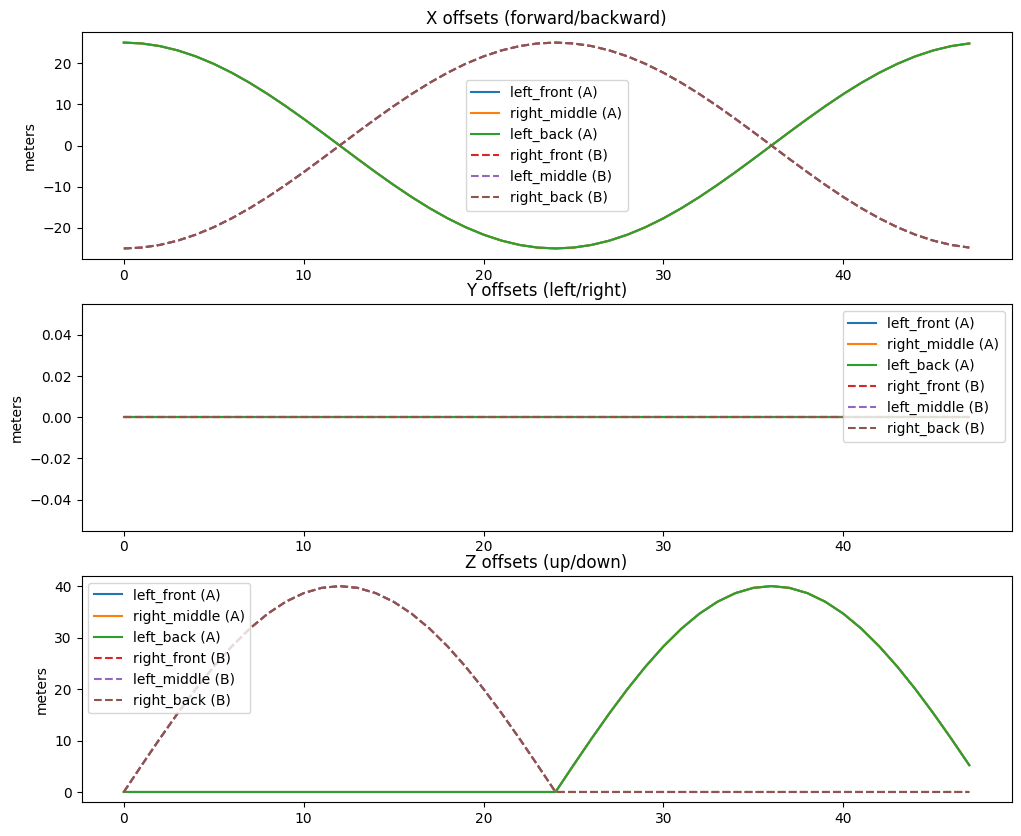

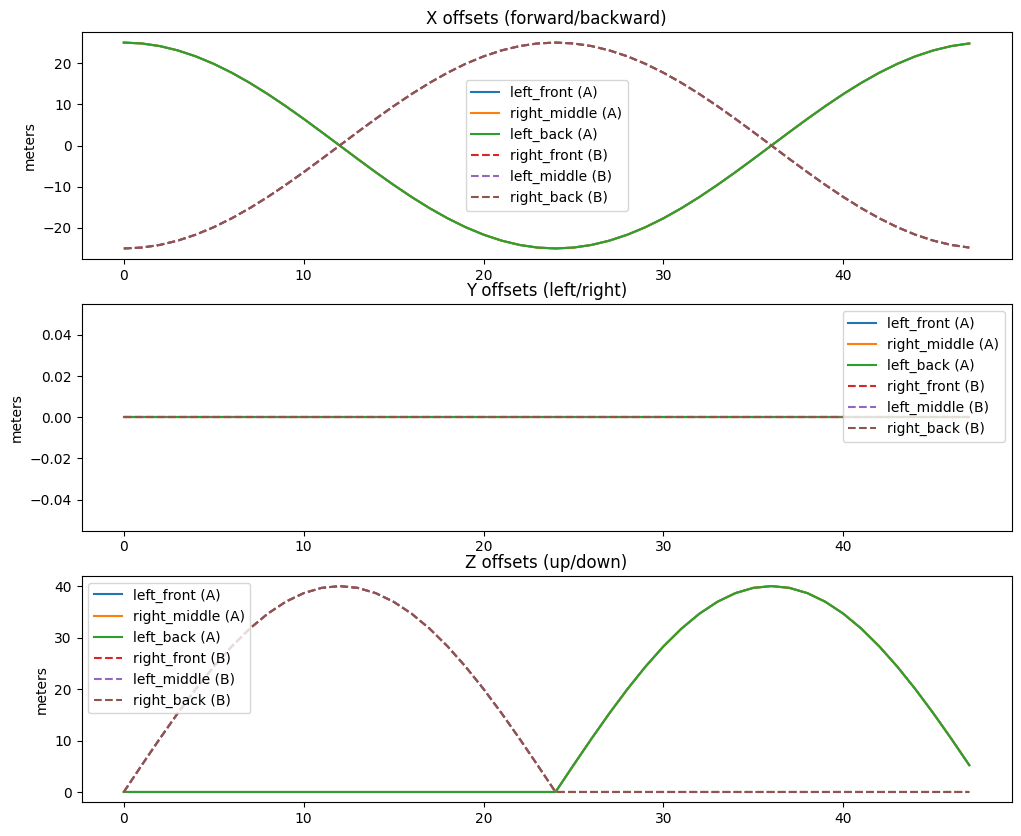

Pose at step 5: {'left_front': Point3D(19.8338, 0.0000, 0.0000, None), 'right_middle': Point3D(19.8338, 0.0000, 0.0000, None), 'left_back': Point3D(19.8338, 0.0000, 0.0000, None), 'right_front': Point3D(-19.8338, 0.0000, 24.3505, None), 'left_middle': Point3D(-19.8338, 0.0000, 24.3505, None), 'right_back': Point3D(-19.8338, 0.0000, 24.3505, None)}


In [14]:
import numpy as np
import matplotlib.pyplot as plt

from point import Point3D


class TripodGaitGenerator:
    def __init__(
        self,
        step_length=50,  # Length of each step in meters
        step_height=40,  # Height of leg lift in meters
        step_count=48,
    ):  # Number of steps in sequence (should be multiple of 4)
        """
        Tripod gait generator for hexapod robot.
        Generates leg tip offsets in right-hand coordinate system (x-forward, y-left, z-up).

        Args:
            step_length: Length of each step in meters
            step_height: Height of leg lift in meters
            step_count: Number of steps in sequence (should be multiple of 4)
        """
        # Store parameters as member fields
        self.step_length = step_length
        self.step_height = step_height
        self.step_count = step_count

        # Define leg groups for tripod gait
        self.tripod_a = ['left_front', 'right_middle', 'left_back']
        self.tripod_b = ['right_front', 'left_middle', 'right_back']

    def generate_sequence(self):
        """Generate the full tripod gait sequence with smooth sine wave movements"""
        # Ensure step_count is multiple of 4 for complete cycles
        if self.step_count % 4 != 0:
            self.step_count = ((self.step_count // 4) + 1) * 4

        # Generate sequences for each leg
        sequences = {}

        # Generate tripod A sequences (first half of cycle in air)
        for leg in self.tripod_a:
            sequences[leg] = self._generate_leg_sequence(0)  # 0 phase offset

        # Generate tripod B sequences (second half of cycle in air)
        for leg in self.tripod_b:
            sequences[leg] = self._generate_leg_sequence(np.pi)  # π phase offset (half cycle)

        return sequences

    def _generate_leg_sequence(self, phase_offset):
        """Generate sequence for a single leg with given phase offset"""
        # Create time points for one complete cycle
        t = np.linspace(0, 2 * np.pi, self.step_count, endpoint=False)

        # Apply phase offset
        t = t + phase_offset

        # X movement: forward during stance phase, backward during swing phase
        x_offsets = self.step_length / 2 * np.cos(t)

        # Z movement: up during swing phase, down during stance phase
        # Using rectified sine wave (only positive during swing phase)
        z_offsets = np.zeros(self.step_count)
        for i in range(self.step_count):
            # Only lift during swing phase (when sine is negative after phase shift)
            if np.sin(t[i]) < 0:
                z_offsets[i] = self.step_height * np.sin(t[i] + np.pi)

        # Y offset is always zero for straight walking
        y_offsets = np.zeros(self.step_count)

        return {'x': x_offsets.tolist(), 'y': y_offsets.tolist(), 'z': z_offsets.tolist()}

    def get_pose_at_step(self, sequences, step):
        """Get the pose at a specific step in the sequence"""
        pose = {}
        for leg_position in sequences.keys():
            pose[leg_position] = Point3D([
                sequences[leg_position]['x'][step % self.step_count],
                sequences[leg_position]['y'][step % self.step_count],
                sequences[leg_position]['z'][step % self.step_count],
            ])
        return pose

    def visualize(self, sequences=None):
        """Visualize the gait sequence"""
        if sequences is None:
            sequences = self.generate_sequence()

        fig, axs = plt.subplots(3, 1, figsize=(12, 10))

        # Plot x offsets
        for leg, data in sequences.items():
            if leg in self.tripod_a:
                axs[0].plot(data['x'], label=f'{leg} (A)', linestyle='-')
            else:
                axs[0].plot(data['x'], label=f'{leg} (B)', linestyle='--')
        axs[0].set_title('X offsets (forward/backward)')
        axs[0].set_ylabel('meters')
        axs[0].legend()

        # Plot y offsets
        for leg, data in sequences.items():
            if leg in self.tripod_a:
                axs[1].plot(data['y'], label=f'{leg} (A)', linestyle='-')
            else:
                axs[1].plot(data['y'], label=f'{leg} (B)', linestyle='--')
        axs[1].set_title('Y offsets (left/right)')
        axs[1].set_ylabel('meters')
        axs[1].legend()

        # Plot z offsets
        for leg, data in sequences.items():
            if leg in self.tripod_a:
                axs[2].plot(data['z'], label=f'{leg} (A)', linestyle='-')
            else:
                axs[2].plot(data['z'], label=f'{leg} (B)', linestyle='--')
        axs[2].set_title('Z offsets (up/down)')
        axs[2].set_ylabel('meters')
        axs[2].legend()

        plt.show()


# Example usage

generator = TripodGaitGenerator()
sequences = generator.generate_sequence()
generator.visualize(sequences)

# Get pose at step 5
pose_at_step_5 = generator.get_pose_at_step(sequences, 5)
print('Pose at step 5:', pose_at_step_5)


This tripod gait generator:

 1. Creates sequences for all 6 legs divided into two tripod groups
 2. Generates coordinated movement patterns where:
    - Tripod A (leftFront, rightMiddle, leftBack) moves in the first half of the cycle
    - Tripod B (rightFront, leftMiddle, rightBack) moves in the second half
    - When one tripod is lifting and moving forward, the other is on the ground providing support
 3. Provides visualization to help understand the gait pattern
 4. Allows you to extract the pose at any step in the sequence
 
The implementation is based on your existing code structure but simplified for clarity. You can adjust parameters like hipSwing, liftSwing, and stepCount to modify the gait characteristics.



In [15]:
from models import HexapodModel
from point import Point3D
from plotting import plot_hexapod, update_hexapod_plot
from matplotlib.animation import FuncAnimation

%matplotlib widget

plt.rcParams["animation.html"] = "jshtml"

skip = False
interactive = False
was_interactive = plt.isinteractive()

if interactive:
  plt.ion()
else:
  plt.ioff()

try:
  if skip:
    raise KeyboardInterrupt

  hexapod = HexapodModel()

  generator = TripodGaitGenerator(step_length=60)
  sequences = generator.generate_sequence()

  hexapod.forward_kinematics(0, -25, 110)
  named_leg_tips = {leg.label: leg.tibia_end.copy() for leg in hexapod.legs}


  def set_pose(step):
      pose = generator.get_pose_at_step(sequences, step)

      for leg, offsets in pose.items():
          leg_tip = named_leg_tips[leg]
          hexapod.named_legs[leg].move_to(leg_tip + offsets)

  fig, ax, plot_data = plot_hexapod(hexapod)

  def animate(frame):
      set_pose(frame)
      update_hexapod_plot(hexapod, plot_data)

  anim = FuncAnimation(fig, animate, frames=len(sequences['left_front']['x']), interval=20)

  if not skip:
    # see plt.ion() / plt.ioff() at the top of this cell
    if not plt.isinteractive():
        display(anim)
except KeyboardInterrupt:
  print("Skipping animation")
finally:
  if was_interactive:
    plt.ion()
  else:
    plt.ioff()